In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class DDPG_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, noise,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.noise = noise
        
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            if self.render:
                env.render()
                
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward

            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                self.terminal_memory.append(1 - terminal) # terminal = 1 if true so 0 if terminal            
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1 
                
            # If more items in memory list than batch size, sample items from each memory list
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item])
                    terminals.append(self.terminal_memory[item])
                
                # Reformat sample lists 
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                
                # Gradient descent on critic prep
                target_actions = self.target_actor(next_states)
                next_Qtargets = self.target_critic(next_states, target_actions)
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i]) # If next state terminal, will be 0
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Gradient descent on critic
                Qexpected = self.critic(states, actions)
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Gradient ascent on actor
                actions_predicted = self.actor(states)
                actor_loss = -self.critic(states, actions_predicted)
                actor_loss = torch.mean(actor_loss)
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))   
                
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
     
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            print('Episode reward:', ep_reward)
            scores.append(ep_reward)
            
        print('Scores during testing')
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()
  
    def visualise(self):
        for i in range(5):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

Episode: 100/2000 Score: -104.842 	 Average over last 100 episodes: -114.606
Episode: 200/2000 Score: -152.216 	 Average over last 100 episodes: -116.291
Episode: 300/2000 Score: -158.684 	 Average over last 100 episodes: -124.417
Episode: 400/2000 Score: -125.123 	 Average over last 100 episodes: -126.413
Episode: 500/2000 Score: -134.929 	 Average over last 100 episodes: -130.142
Episode: 600/2000 Score: -136.661 	 Average over last 100 episodes: -125.707
Episode: 700/2000 Score: -124.236 	 Average over last 100 episodes: -110.634
Episode: 800/2000 Score: -124.358 	 Average over last 100 episodes: -62.463
Episode: 900/2000 Score: -155.241 	 Average over last 100 episodes: -137.322
Episode: 1000/2000 Score: -54.795 	 Average over last 100 episodes: -131.018
Episode: 1100/2000 Score: -100.684 	 Average over last 100 episodes: -61.846
Episode: 1200/2000 Score: -104.375 	 Average over last 100 episodes: -16.546
Episode: 1300/2000 Score: -27.366 	 Average over last 100 episodes: -67.640
E

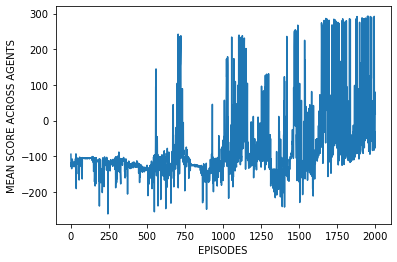

In [5]:
environment = 'BipedalWalker-v3' # Change environment name here
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
elif environment == 'LunarLanderContinuous-v2' or 'BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1

agents = 2
episodes = 2000
all_scores = []
all_moving_means = [] # Mean score of the last X episodes
previous = 100 # Set value of X 

for i in range(1, agents + 1):
    
    agent = DDPG_Agent(scaling = scaling, render = False, buffer_size = 1000000, batch_size = 100, gamma = 0.99, tau = 0.001, noise = 0.05,
                state_size = env.observation_space.shape[0], hidden_size = 300, action_size = env.action_space.shape[0], actor_lr = 0.0001, critic_lr = 0.001)
    agent_scores = []
    agent_moving_means = []
    
    for j in range(1, episodes + 1):
        
        ep_reward = agent.train()
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 
        
        if j % 100 == 0: # How often to print
            print('Episode: {}/{} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(j, episodes, ep_reward, previous, agent_moving_means[j-1])) 
            
    print('*************************************************************')
    print('Agent {} complete \t Mean score of agent: {:.2f}'.format(i, np.mean(agent_scores))) 
    print('*************************************************************')
    all_scores.append(agent_scores)
    all_moving_means.append(agent_moving_means)

all_scores = np.array(all_scores)
average_score = all_scores.mean(0) # Average the scores across agents
x = [i for i in range(1, len(average_score) + 1)]
print('Scores during training')
plt.plot(x, average_score)
plt.ylabel('Score averaged across agents')
plt.xlabel('Episodes')              
plt.show()

all_moving_means = np.array(all_moving_means)
average_moving_mean = all_moving_means.mean(0) # Average the means across agents
x = [i for i in range(1, len(average_moving_mean) + 1)]
print('Mean score of last {} episodes during training'.format(previous))
plt.plot(x, average_moving_mean)
plt.ylabel('Mean score of last {} episodes averaged across agents'.format(previous))       
plt.xlabel('Episodes')
plt.show()

Episode reward: -56.5715262780146
Episode reward: -47.20780304998336
Episode reward: -61.34620278371198
Episode reward: -78.5170379753417
Episode reward: -47.83170371051615
Episode reward: -53.39416271807816
Episode reward: -70.02245623730732
Episode reward: -40.40128883261935
Episode reward: -64.03442781125254
Episode reward: -67.73521679273765
Episode reward: -39.68557802111605
Episode reward: -45.993113274891144
Episode reward: -56.90106961846993
Episode reward: -83.53808686374505
Episode reward: -62.3831266841894
Episode reward: -65.73739471877215
Episode reward: -51.75342488860112
Episode reward: -55.90499145631849
Episode reward: -51.469397385273325
Episode reward: -67.13207795879723
Episode reward: -57.08870972936761
Episode reward: -45.731636959394734
Episode reward: -51.40165885881447
Episode reward: -58.73018919906338
Episode reward: -45.65230366910101
Episode reward: -61.25439080054357
Episode reward: -50.25033324270474
Episode reward: -62.63538057507198
Episode reward: -60.

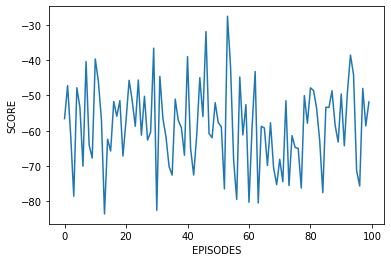

In [6]:
agent.test()

In [8]:
agent.visualise()

2022-05-02 23:05:44.927 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa895910410>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:44.928 python[8201:257175] Warning: Expected min height of view: (<NSButton: 0x7fa89552b040>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:44.930 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa89553be70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:44.931 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa89553e610>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -48.86008901002414


2022-05-02 23:05:47.097 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8955046d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:47.098 python[8201:257175] Warning: Expected min height of view: (<NSButton: 0x7fa89551ca20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:47.100 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8955061c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:47.102 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa895506dd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -63.29256797627759


2022-05-02 23:05:50.994 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa89590ef10>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:50.995 python[8201:257175] Warning: Expected min height of view: (<NSButton: 0x7fa892dce2a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:50.997 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa892dcea30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:50.998 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa892dcfdb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -37.852092750433535


2022-05-02 23:05:55.383 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa895504aa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:55.383 python[8201:257175] Warning: Expected min height of view: (<NSButton: 0x7fa895543700>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:55.385 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa895521d00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:55.387 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa89551f610>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -76.09773721526295


2022-05-02 23:05:58.613 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8affcbce0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:58.617 python[8201:257175] Warning: Expected min height of view: (<NSButton: 0x7fa8aff7e3e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:58.628 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8aff7eb70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 23:05:58.640 python[8201:257175] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8aff77f50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -49.96334955692221
